## Learn-To-Rank (LightGBM; Pointwise ranking)

In [2]:

import pandas as pd

anime_info_df = pd.read_csv('anime_info.csv')
relavence_scores = pd.read_csv('relavence_scores.csv')
user_info = pd.read_csv('user_info.csv')


Show columns and clean data

In [3]:
anime_info_df.head()

,anime_id,Genres,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1,1998.0,1,4012.0,4012.0,0.594018
1,5,"Action, Drama, Mystery, Sci-Fi, Space",0,2001.0,1,NaN,NaN,NaN
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",1,1998.0,0,NaN,NaN,NaN
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",1,2002.0,0,NaN,NaN,NaN
4,8,"Adventure, Fantasy, Shounen, Supernatural",1,2004.0,0,76.0,76.0,0.481013


In [4]:
anime_info_df.isnull().sum()

anime_id                       0
Genres                        54
is_tv                          0
year_aired                   123
is_adult                       0
above_five_star_users      11012
above_five_star_ratings    11012
above_five_star_ratio      11012
dtype: int64

In [5]:
#Drop Genres nulls since treat as important features
anime_info_df.dropna(subset=['Genres'],inplace=True)

#Fill numeric columns nulls with avg
anime_info_df[['year_aired','above_five_star_users','above_five_star_ratings','above_five_star_ratio']]= anime_info_df[['year_aired','above_five_star_users','above_five_star_ratings','above_five_star_ratio']].fillna(anime_info_df[['year_aired','above_five_star_users','above_five_star_ratings','above_five_star_ratio']].mean())

In [6]:
user_info.head()

,user_id,review_count,avg_score,score_stddev,above_five_star_count,above_five_star_ratio
0,3,357,6.801120,2.475089,318.0,0.890756
1,6,545,4.089908,3.731472,285.0,0.522936
2,8,165,0.866667,2.448328,NaN,NaN
3,13,65,3.338462,4.191796,NaN,NaN
4,14,146,4.965753,3.844233,89.0,0.609589


In [7]:
user_info.isnull().sum()

user_id                     0
review_count                0
avg_score                   0
score_stddev              140
above_five_star_count    6532
above_five_star_ratio    6532
dtype: int64

In [8]:
#Fill numeric columns nulls with avg
user_info[['score_stddev','above_five_star_count','above_five_star_ratio']]=user_info[['score_stddev','above_five_star_count','above_five_star_ratio']].fillna(user_info[['score_stddev','above_five_star_count','above_five_star_ratio']].mean())

In [9]:
relavence_scores.head()

,anime_id,Name,user_id,relavence_score
0,1,Cowboy Bebop,3,1.000000
1,1,Cowboy Bebop,6,1.000000
2,1,Cowboy Bebop,8,0.230769
3,1,Cowboy Bebop,13,0.000000
4,1,Cowboy Bebop,14,0.500000


In [10]:
relavence_scores.isnull().sum()

anime_id           0
Name               0
user_id            0
relavence_score    0
dtype: int64

Merging above 3 datasets to get overall info of user_id (query),anime_id (document), relavance_score, and other features.

In [11]:
anime_info_df.Genres.unique()

array(['Action, Adventure, Comedy, Drama, Sci-Fi, Space',
       'Action, Drama, Mystery, Sci-Fi, Space',
       'Action, Sci-Fi, Adventure, Comedy, Drama, Shounen', ...,
       'Sci-Fi, Music, Mecha',
       'Mystery, Psychological, Supernatural, Thriller, Shounen',
       'Martial Arts, Fantasy'], dtype=object)


Choose popular genres as new features.

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt

anime_info_df['Genres'] = anime_info_df['Genres'].apply(lambda x:",".join(s.strip() for s in x.split(",")))

# use MultiLabelBinarizer to create a one-hot encoded dataframe of the genres
mlb = MultiLabelBinarizer()
genre_df = pd.DataFrame(mlb.fit_transform(anime_info_df['Genres'].str.split(',')),
                        columns=mlb.classes_,
                        index=anime_info_df.index)

#Choose popular/at interest genres as new features
feature_genres = ['Comedy',
 'Action',
 'Fantasy',
 'Adventure',
 'Kids',
 'Drama',
 'Sci-Fi',
 'Music',
 'Shounen',
 'Slice of Life',
 'Supernatural']

#pair genres with anime id
feature_genres_info=pd.concat([anime_info_df['anime_id'],genre_df[feature_genres]],axis=1)

#merge with anime_info_df
anime_info_df_final = anime_info_df.merge(feature_genres_info,on='anime_id')

#rename feature columns for better reference
anime_info_df_final.columns = [col if col=='anime_id' else f"ANIME_FEATURE {col}".upper() for col in anime_info_df_final.columns]
user_info.columns = [col if col=='user_id' else f"USER_FEATURE {col}".upper() for col in user_info.columns]




In [120]:
#merge all data to get the train data
traindf=pd.merge(pd.merge(relavence_scores,user_info, on='user_id'),anime_info_df_final,on='anime_id')
traindf.head()

,anime_id,Name,user_id,relavence_score,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE,USER_FEATURE SCORE_STDDEV,USER_FEATURE ABOVE_FIVE_STAR_COUNT,USER_FEATURE ABOVE_FIVE_STAR_RATIO,ANIME_FEATURE GENRES,...,ANIME_FEATURE ACTION,ANIME_FEATURE FANTASY,ANIME_FEATURE ADVENTURE,ANIME_FEATURE KIDS,ANIME_FEATURE DRAMA,ANIME_FEATURE SCI-FI,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE SLICE OF LIFE,ANIME_FEATURE SUPERNATURAL
0,1,Cowboy Bebop,3,1.000000,357,6.801120,2.475089,318.000000,0.890756,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",...,1,0,1,0,1,1,0,0,0,0
1,1,Cowboy Bebop,6,1.000000,545,4.089908,3.731472,285.000000,0.522936,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",...,1,0,1,0,1,1,0,0,0,0
2,1,Cowboy Bebop,8,0.230769,165,0.866667,2.448328,209.291276,0.708196,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",...,1,0,1,0,1,1,0,0,0,0
3,1,Cowboy Bebop,13,0.000000,65,3.338462,4.191796,209.291276,0.708196,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",...,1,0,1,0,1,1,0,0,0,0
4,1,Cowboy Bebop,14,0.500000,146,4.965753,3.844233,89.000000,0.609589,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",...,1,0,1,0,1,1,0,0,0,0


In [121]:
traindf.columns

Index(['anime_id', 'Name', 'user_id', 'relavence_score',
       'USER_FEATURE REVIEW_COUNT', 'USER_FEATURE AVG_SCORE',
       'USER_FEATURE SCORE_STDDEV', 'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE GENRES',
       'ANIME_FEATURE IS_TV', 'ANIME_FEATURE YEAR_AIRED',
       'ANIME_FEATURE IS_ADULT', 'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE DRAMA',
       'ANIME_FEATURE SCI-FI', 'ANIME_FEATURE MUSIC', 'ANIME_FEATURE SHOUNEN',
       'ANIME_FEATURE SLICE OF LIFE', 'ANIME_FEATURE SUPERNATURAL'],
      dtype='object')

In [122]:
#sort by query                                     
traindf.sort_values(by='user_id',inplace=True)
traindf.set_index("user_id",inplace=True)

#target is relavence_score, with USER_FEATURE columns and ANMIE_FEATURE columns as input.
Target=traindf.relavence_score
Feature=traindf.drop(['anime_id','Name','relavence_score','ANIME_FEATURE GENRES'],axis=1)

test_size = 200000
X,y = Feature,Target.apply(lambda x:int(x * 10))
test_idx_start = len(X)-test_size

xtrain,xtest,ytrain,ytest = X.iloc[0:test_idx_start],X.iloc[test_idx_start:],y.iloc[0:test_idx_start],y.iloc[test_idx_start:]


In [125]:
get_group_size = lambda df: df.reset_index().groupby('user_id')['user_id'].count()

train_groups = get_group_size(xtrain)
test_groups = get_group_size(xtest)

print("Training data voulme is {a}, and test data volume is {b}.".format(a=sum(train_groups),b=sum(test_groups)))


Training data voulme is 4678575, and test data volume is 200000.


In [126]:
import lightgbm as lgb


Model training result, measured by Ndcg.

In [127]:
model = lgb.LGBMRanker(objective="lambdarank")
model.fit(xtrain,ytrain,group=train_groups,eval_set=[(xtest,ytest)],eval_group=[test_groups],eval_metric=['ndcg'])


[1]	valid_0's ndcg@1: 0.842823	valid_0's ndcg@2: 0.842346	valid_0's ndcg@3: 0.845918	valid_0's ndcg@4: 0.848058	valid_0's ndcg@5: 0.844909
[2]	valid_0's ndcg@1: 0.866985	valid_0's ndcg@2: 0.872058	valid_0's ndcg@3: 0.870681	valid_0's ndcg@4: 0.865368	valid_0's ndcg@5: 0.862506
[3]	valid_0's ndcg@1: 0.870255	valid_0's ndcg@2: 0.876163	valid_0's ndcg@3: 0.874679	valid_0's ndcg@4: 0.867872	valid_0's ndcg@5: 0.867904
[4]	valid_0's ndcg@1: 0.875124	valid_0's ndcg@2: 0.874138	valid_0's ndcg@3: 0.874981	valid_0's ndcg@4: 0.872077	valid_0's ndcg@5: 0.87034
[5]	valid_0's ndcg@1: 0.868645	valid_0's ndcg@2: 0.875891	valid_0's ndcg@3: 0.873527	valid_0's ndcg@4: 0.871839	valid_0's ndcg@5: 0.871638
[6]	valid_0's ndcg@1: 0.875138	valid_0's ndcg@2: 0.879263	valid_0's ndcg@3: 0.877626	valid_0's ndcg@4: 0.874971	valid_0's ndcg@5: 0.873141
[7]	valid_0's ndcg@1: 0.878385	valid_0's ndcg@2: 0.880622	valid_0's ndcg@3: 0.876679	valid_0's ndcg@4: 0.875651	valid_0's ndcg@5: 0.872656
[8]	valid_0's ndcg@1: 0.8832

LGBMRanker(objective='lambdarank')

Predict with ranking model based on "candidate documents (animes)" (animes that users may be not interested in).

In [128]:
#choose user_id=1 for example
#animes that user1 has already liked:
liked_anime=relavence_scores.loc[relavence_scores['user_id']==1]['anime_id'].tolist()

#all animes:
animes_pool = anime_info_df_final['anime_id'].unique().tolist()

#candidate animes
candidates = list(set(animes_pool)-set(liked_anime))

In [150]:
#Merge candidates with features, name as 'anime_id'
df_candidates=pd.DataFrame(data=pd.Series(candidates,name='anime_id'))
    
Feature= anime_info_df_final.merge(df_candidates)
    
Feature['user_id']=1


Feature= Feature.merge(user_info).drop(['anime_id','ANIME_FEATURE GENRES'],axis=1)
Feature.set_index("user_id",inplace=True)
    
#get anime names
predictions=pd.DataFrame(index=candidates)
predictions['anime_id']=pd.Series(candidates)
predictions['anime_name']=df_candidates.merge(relavence_scores)['Name']
  

In [133]:
    
#predict results
predictions['ranking_score']= model.predict(Feature)
#order by ranking
predictions.sort_values(by='ranking_score',ascending=False)
    

,anime_id,anime_name,ranking_score
1030,1144.0,Cowboy Bebop,1.448078
19291,NaN,Naruto,1.434598
4026,5263.0,Cowboy Bebop,1.434598
2201,2422.0,Cowboy Bebop,1.410574
3641,4481.0,Cowboy Bebop,1.324245
...,...,...,...
10030,29846.0,Trigun,-1.901910
32,53.0,Cowboy Bebop,-1.936130
31798,NaN,Neon Genesis Evangelion,-1.936130
2236,2459.0,Cowboy Bebop,-1.936130


Above is the prediction result of User_id=1 preferred animes. Test validation data is based on candidates (the animes have not been liked).

 92%|==================  | 4622/5000 [00:12<00:00]       

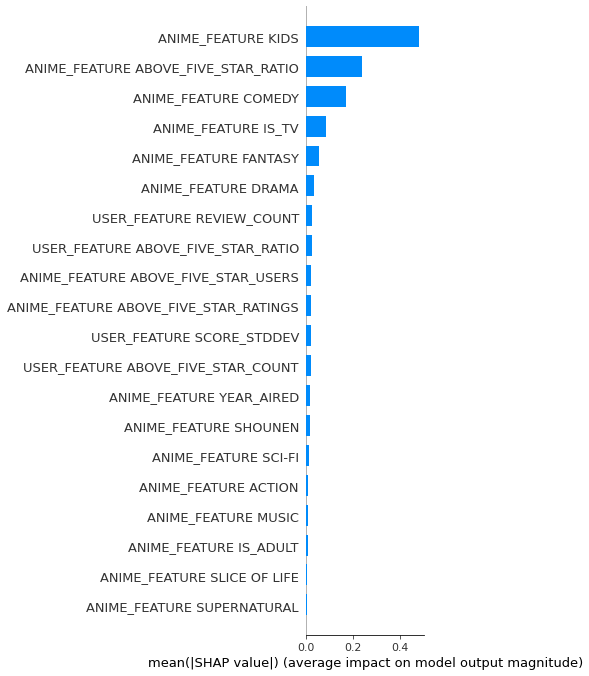

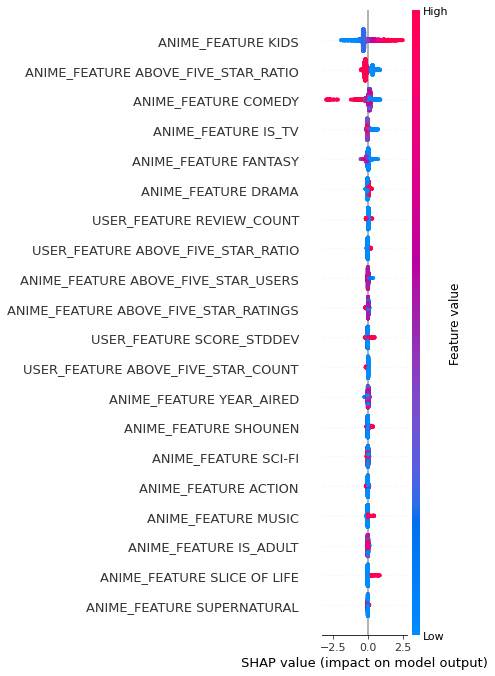

In [149]:
import shap

def generate_shap_plots(ranker, X_train, feature_names, N):
    """
    Generates SHAP plots for a pre-trained LightGBM model.
    
    Parameters:
        ranker (lightgbm.Booster): A trained LightGBM model
        X_train (np.ndarray): The training data used to fit the model
        feature_names (List): list of feature names
        N (int): The number of plots to generate
    
    Returns:
        None
    """
    explainer = shap.Explainer(ranker, X_train, feature_names=feature_names)
    shap_values = explainer(X_train.iloc[:N])
    
    # summary plot1, shows overall contribution of each feature to final result
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar')
    
    # summary plot2, y-axis is feature value, x-axis is shap value
    plt.subplot(1, 2, 2)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')
    
    plt.show()

generate_shap_plots(model,xtrain,Feature.columns.tolist(),N=5000)

Conclusion for User_id=1:

The anime feature "Kids" has the most contribution to the final prediction result and they're postively related. When the anime has "Kids" feature, the final ranking score will be increased.
The other feature "Comedy" also has high contribution to predicted ranking score, but negatively related. When the anime has "Comedy" feature, the final ranking score will be decreased.